In order to analyze more sufficient data, I resort to another artist---Rambrandt van Rijn---the leading figure of Dutch Golden Age.

# Dataset2: Rembrandt van Rijn

In [3]:
import requests
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [10]:
api_key ="XXX"
principalMaker="Rembrandt+van+Rijn"
url="https://www.rijksmuseum.nl/api/nl/collection?key="+api_key+"&principalMaker="+principalMaker
response = requests.get(url).json()
response

{'elapsedMilliseconds': 0,
 'count': 1554,
 'countFacets': {'hasimage': 1532, 'ondisplay': 18},
 'artObjects': [{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-C-5',
    'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-C-5'},
   'id': 'nl-SK-C-5',
   'objectNumber': 'SK-C-5',
   'title': 'De Nachtwacht',
   'hasImage': True,
   'principalOrFirstMaker': 'Rembrandt van Rijn',
   'longTitle': 'De Nachtwacht, Rembrandt van Rijn, 1642',
   'showImage': True,
   'permitDownload': True,
   'webImage': {'guid': 'bbd1fae8-4023-4859-8ed1-d38616aec96c',
    'offsetPercentageX': 0,
    'offsetPercentageY': 1,
    'width': 5656,
    'height': 4704,
    'url': 'https://lh3.googleusercontent.com/SsEIJWka3_cYRXXSE8VD3XNOgtOxoZhqW1uB6UFj78eg8gq3G4jAqL4Z_5KwA12aD7Leqp27F653aBkYkRBkEQyeKxfaZPyDx0O8CzWg=s0'},
   'headerImage': {'guid': '29a2a516-f1d2-4713-9cbd-7a4458026057',
    'offsetPercentageX': 0,
    'offsetPercentageY': 0,
    'width': 1920,
    'height': 460,
    'url': 'https:

In [ ]:
#extract normalizedcolors;
normalizedcolors=response['facets'][6]['facets']
print(normalizedcolors)

[{'key': ' #737C84', 'value': 865}, {'key': ' #2F4F4F', 'value': 691}, {'key': '#FBF6E1', 'value': 658}, {'key': ' #E0CC91', 'value': 443}, {'key': ' #F6ECF3', 'value': 342}, {'key': ' #FBF6E1', 'value': 304}, {'key': '#2F4F4F', 'value': 105}, {'key': ' #000000', 'value': 102}, {'key': ' #B5BFCC', 'value': 100}, {'key': '#737C84', 'value': 94}, {'key': '#E0CC91', 'value': 79}, {'key': ' #B35A1F', 'value': 47}, {'key': '#000000', 'value': 32}, {'key': '#F6ECF3', 'value': 8}, {'key': ' #367614', 'value': 6}, {'key': '#B5BFCC', 'value': 5}, {'key': ' #E09714', 'value': 4}, {'key': ' #F49B7A', 'value': 4}, {'key': '#B35A1F', 'value': 3}, {'key': ' #4279DB', 'value': 1}, {'key': ' #6CD928', 'value': 1}, {'key': ' #DAAFDA', 'value': 1}, {'key': ' #F319F5', 'value': 1}]


In [ ]:
#summerize color and its corresponding value(frequency) in a dictionary;
colors_fre = {}
for ele in normalizedcolors:
    key = ele['key'].lstrip()
    value = ele['value']
    colors_fre[key] = colors_fre.get(key, 0) + value
print(colors_fre)

{'#737C84': 959, '#2F4F4F': 796, '#FBF6E1': 962, '#E0CC91': 522, '#F6ECF3': 350, '#000000': 134, '#B5BFCC': 105, '#B35A1F': 50, '#367614': 6, '#E09714': 4, '#F49B7A': 4, '#4279DB': 1, '#6CD928': 1, '#DAAFDA': 1, '#F319F5': 1}


## STEP1 Data Acquisition 

The collection API shows that there are roughly 1552 works of Rembrandt van Rijn in Rijks Database. As I was told by the staff of Rijksmuesem that each page shows maximum 100 items. So I retrieve from page 1 to 16, and save each page into a csv file. Then merge the 16 csv files into one.

In order to analyze the color more effectively, I also add a new parameter(Majorcolor) which I select the color with the largest proportion from the hex color code.

Later, I add a loop to retrieve data by one step.

In [4]:
api_key ="XXX"
principalMaker="Rembrandt+van+Rijn"
df_r = pd.DataFrame(columns=['object_id','objectNumber','title','maker','width','height'])

# Loop over all pages
for page_num in range(1, 17):
    url=f"https://www.rijksmuseum.nl/api/nl/collection?key={api_key}&principalMaker={principalMaker}&chronologic&ps=100&p={page_num}"
    response = requests.get(url).json()

    # Process each art object in the current page
    for artobject in response['artObjects']:
      if artobject is not None:
        object_id = artobject.get('id')
        objectNumber = artobject.get('objectNumber')
        title = artobject.get('title')
        webImage = artobject.get('webImage')
        url_image = webImage.get('url') if webImage is not None else None
        maker = artobject.get('principalOrFirstMaker')
        width = webImage.get('width') if webImage is not None else None
        height = webImage.get('height') if webImage is not None else None
#then use objectNumber as the primary key to link details;
#remove T in time and turn list into str;
        url_detail = "https://www.rijksmuseum.nl/api/nl/collection/"+objectNumber+"?key="+api_key
        response_detail = requests.get(url_detail).json()
        colors = response_detail['artObject']['colors']
        if len(colors) > 0:
          largest_hex = max(colors, key=lambda x: x['percentage'])['hex'].strip()
          colors_WithNormalization = response_detail['artObject']['colorsWithNormalization']
          normalizedColors = response_detail['artObject']['normalizedColors']
        else:
          largest_hex = ''
          colors_WithNormalization = ''
          normalizedColors = ''
        description = response_detail['artObject']['description']
        presentingDate = response_detail['artObject']['dating']['presentingDate']
        placeOfBirth = response_detail['artObject']['principalMakers'][0]['placeOfBirth']
        dateOfBirth = response_detail['artObject']['principalMakers'][0]['dateOfBirth']
        placeOfDeath = response_detail['artObject']['principalMakers'][0]['placeOfDeath']
        dateOfDeath = response_detail['artObject']['principalMakers'][0]['dateOfDeath']
        occupation = response_detail['artObject']['principalMakers'][0]['occupation']
        occupation_str = ", ".join(occupation) 
        roles = response_detail['artObject']['principalMakers'][0]['roles']
        roles_str = ", ".join(roles) 
        nationality = response_detail['artObject']['principalMakers'][0]['nationality']
        productionPlaces = response_detail['artObject']['principalMakers'][0]['productionPlaces']
        productionPlaces_str = ", ".join(productionPlaces)
        acquisition_method = response_detail['artObject']['acquisition']['method']
        acquisition_date = response_detail['artObject']['acquisition']['date']
        if acquisition_date is not None:
          acquisition_date = acquisition_date.split('T')[0]
        else:
          acquisition_date = 'None'
        materials = response_detail['artObject']['materials']
        materials_str = ", ".join(materials)
        iconClassDescription = response_detail['artObject']['classification']['iconClassDescription']
        iconClassDescription_str = ", ".join(iconClassDescription)
        physicalMedium = response_detail['artObject']['physicalMedium'] 
 
 #append all data needed into pandas dataframe;     
        df_r=df_r.append({'object_id':object_id, 'objectNumber':objectNumber,
         'title':title,'url':url_image, 'maker':maker,
          'width':width, 'height':height,'largest_hex':largest_hex,
          'colors':colors,'colors_WithNormalization':colors_WithNormalization, 
          'normalizedColors':normalizedColors,'description':description,
           'placeOfBirth':placeOfBirth, 'dateOfBirth':dateOfBirth,
            'placeOfDeath':placeOfDeath, 'dateOfDeath':dateOfDeath,
            'occupation':occupation_str, 'roles':roles_str,
            'nationality':nationality, 'productionPlaces':productionPlaces_str,
             'acquisition_method':acquisition_method, 'acquisition_date':acquisition_date,
             'materials':materials_str,'iconClassDescription':iconClassDescription_str,
             'physicalMedium':physicalMedium,'presentingDate':presentingDate}, ignore_index=True)
      else:
        continue

/var/folders/x7/2_kqx0w15sb52_lb12v8t4nm0000gn/T/ipykernel_29817/35162581.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_r=df_r.append({'object_id':object_id, 'objectNumber':objectNumber,
/var/folders/x7/2_kqx0w15sb52_lb12v8t4nm0000gn/T/ipykernel_29817/35162581.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_r=df_r.append({'object_id':object_id, 'objectNumber':objectNumber,
/var/folders/x7/2_kqx0w15sb52_lb12v8t4nm0000gn/T/ipykernel_29817/35162581.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_r=df_r.append({'object_id':object_id, 'objectNumber':objectNumber,
/var/folders/x7/2_kqx0w15sb52_lb12v8t4nm0000gn/T/ipykernel_29817/35162581.py:64: FutureWarning: The frame.append method is deprecated and will

In [ ]:
#set pandas to show all rows instead of limited rows
pd.set_option('display.max_rows', None)

In [7]:
# drop rows where there are no value in the color columns;
df_r['colors_WithNormalization'].replace('', np.nan, inplace=True)
df_r = df_r.dropna(axis=0, subset=['colors_WithNormalization'])
df_r

,object_id,objectNumber,title,maker,width,height,url,largest_hex,colors,colors_WithNormalization,...,occupation,roles,nationality,productionPlaces,acquisition_method,acquisition_date,materials,iconClassDescription,physicalMedium,presentingDate
0,nl-SK-C-5,SK-C-5,De Nachtwacht,Rembrandt van Rijn,5656,4704,https://lh3.googleusercontent.com/SsEIJWka3_cY...,#261808,"[{'percentage': 81, 'hex': '#261808'}, {'perce...","[{'originalHex': '#261808', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,Amsterdam,bruikleen,1808-01-01,"doek, olieverf","warfare; military affairs (+ citizen soldiery,...",olieverf op doek,1642
1,nl-SK-C-597,SK-C-597,"Portret van een vrouw, mogelijk Maria Trip",Rembrandt van Rijn,2031,2676,https://lh3.googleusercontent.com/AyiKhdEWJ7Xm...,#0B0906,"[{'percentage': 67, 'hex': '#0B0906'}, {'perce...","[{'originalHex': '#0B0906', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,bruikleen,1897-05-01,"paneel, olieverf","historical persons - BB - woman, fan, lace, pe...",olieverf op paneel,1639
2,nl-SK-C-6,SK-C-6,De waardijns van het Amsterdamse lakenbereider...,Rembrandt van Rijn,3000,1975,https://lh3.googleusercontent.com/gShVRyvLLbwV...,#16130C,"[{'percentage': 1, 'hex': '#8B7759'}, {'percen...","[{'originalHex': '#8B7759', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,bruikleen,1808-01-01,"doek, olieverf","officers trusted with control of quality, tabl...",olieverf op doek,1662
4,nl-SK-A-4050,SK-A-4050,Zelfportret als de apostel Paulus,Rembrandt van Rijn,2287,2724,https://lh3.googleusercontent.com/NrCcfeY0r2F3...,#0B0906,"[{'percentage': 65, 'hex': '#0B0906'}, {'perce...","[{'originalHex': '#0B0906', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,legaat,1961-01-01,"doek, olieverf",the apostle Paul of Tarsus; possible attribute...,olieverf op doek,1661
8,nl-SK-A-91,SK-A-91,Salome ontvangt het hoofd van Johannes de Doper,Rembrandt van Rijn,2105,2616,https://lh3.googleusercontent.com/sB8bcd5NQmry...,#1A140E,"[{'percentage': 41, 'hex': '#1A140E'}, {'perce...","[{'originalHex': '#1A140E', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,aankoop,1801-01-01,"doek, olieverf",Salome is given the head of John the Baptist b...,olieverf op doek,ca. 1640 - ca. 1645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,nl-RP-P-1962-28,RP-P-1962-28,De presentatie in de tempel: donkere plaat,Rembrandt van Rijn,2323,3000,https://lh3.ggpht.com/Eaw2htzBVgztMeEIKRNbGDQ1...,#4A4942,"[{'percentage': 57, 'hex': '#4A4942'}, {'perce...","[{'originalHex': '#4A4942', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",prentmaker,Noord-Nederlands,,legaat,1962-01-01,papier,"Simeon, holding the Christ-child, sings his ca...",ets en droge naald,ca. 1654
1488,nl-RP-P-1987-171,RP-P-1987-171,De Madonna in de wolken,Rembrandt van Rijn,2162,3000,https://lh4.ggpht.com/DHt07_KrBvf0XUU5chMS0ygX...,#E8E2D3,"[{'percentage': 58, 'hex': '#E8E2D3'}, {'perce...","[{'originalHex': '#E8E2D3', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",prentmaker,Noord-Nederlands,,legaat,1987-01-01,papier,Madonna (i.e. Mary with the Christ-child) in t...,ets en droge naald,1641
1490,nl-RP-T-00-224,RP-T-00-224,Man met baard en bontmuts,Rembrandt van Rijn,1990,2604,https://lh6.ggpht.com/u4-SoudwkMjIFU0u4zPpMwFS...,#EEE7D6,"[{'percentage': 3, 'hex': '#FDFCF6'}, {'percen...","[{'originalHex': '#FDFCF6', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",tekenaar,Noord-Nederlands,,onbekend,None,"perkament, krijt",head-gear (with NAME),zwart krijt op perkament,1625 - 1710
1503,nl-RP-P-OB-641,RP-P-OB-641,Student aan tafel bij kaarslicht,"Salomon Savery, Rembrandt van Rijn",2500,2407,https://lh3.googleusercontent.com/-JNQqh5WAPk0...,#F7F3E5,"[{'percentage': 50, 'hex': '#F7F3E5'}, {'perce...","[{'originalHex': '#F7F3E5', 'norm

Among the 1508 works, 1246 of them have color related data;

In [ ]:
#save csv file
df_r.to_csv("Rembrandt van Rijn.csv")

In [26]:
df_r.head()

,object_id,objectNumber,title,maker,width,height,url,largest_hex,colors,colors_WithNormalization,...,occupation,roles,nationality,productionPlaces,acquisition_method,acquisition_date,materials,iconClassDescription,physicalMedium,presentingDate
0,nl-SK-C-5,SK-C-5,De Nachtwacht,Rembrandt van Rijn,5656,4704,https://lh3.googleusercontent.com/SsEIJWka3_cY...,#261808,"[{'percentage': 81, 'hex': '#261808'}, {'perce...","[{'originalHex': '#261808', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,Amsterdam,bruikleen,1808-01-01,"doek, olieverf","warfare; military affairs (+ citizen soldiery,...",olieverf op doek,1642
1,nl-SK-C-597,SK-C-597,"Portret van een vrouw, mogelijk Maria Trip",Rembrandt van Rijn,2031,2676,https://lh3.googleusercontent.com/AyiKhdEWJ7Xm...,#0B0906,"[{'percentage': 67, 'hex': '#0B0906'}, {'perce...","[{'originalHex': '#0B0906', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,bruikleen,1897-05-01,"paneel, olieverf","historical persons - BB - woman, fan, lace, pe...",olieverf op paneel,1639
2,nl-SK-C-6,SK-C-6,De waardijns van het Amsterdamse lakenbereider...,Rembrandt van Rijn,3000,1975,https://lh3.googleusercontent.com/gShVRyvLLbwV...,#16130C,"[{'percentage': 1, 'hex': '#8B7759'}, {'percen...","[{'originalHex': '#8B7759', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,bruikleen,1808-01-01,"doek, olieverf","officers trusted with control of quality, tabl...",olieverf op doek,1662
4,nl-SK-A-4050,SK-A-4050,Zelfportret als de apostel Paulus,Rembrandt van Rijn,2287,2724,https://lh3.googleusercontent.com/NrCcfeY0r2F3...,#0B0906,"[{'percentage': 65, 'hex': '#0B0906'}, {'perce...","[{'originalHex': '#0B0906', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,legaat,1961-01-01,"doek, olieverf",the apostle Paul of Tarsus; possible attribute...,olieverf op doek,1661
8,nl-SK-A-91,SK-A-91,Salome ontvangt het hoofd van Johannes de Doper,Rembrandt van Rijn,2105,2616,https://lh3.googleusercontent.com/sB8bcd5NQmry...,#1A140E,"[{'percentage': 41, 'hex': '#1A140E'}, {'perce...","[{'originalHex': '#1A140E', 'normalizedHex': '...",...,"prentmaker, tekenaar, schilder",schilder,Noord-Nederlands,,aankoop,1801-01-01,"doek, olieverf",Salome is given the head of John the Baptist b...,olieverf op doek,ca. 1640 - ca. 1645


In [8]:
#remove less relevant items;
df_r = df_r[[
          'objectNumber', 'title', 'largest_hex',
          'colors','presentingDate','productionPlaces',
          'iconClassDescription','description' ]].copy()
df_r

,objectNumber,title,largest_hex,colors,presentingDate,productionPlaces,iconClassDescription,description
0,SK-C-5,De Nachtwacht,#261808,"[{'percentage': 81, 'hex': '#261808'}, {'perce...",1642,Amsterdam,"warfare; military affairs (+ citizen soldiery,...",Officieren en andere schutters van wijk II in ...
1,SK-C-597,"Portret van een vrouw, mogelijk Maria Trip",#0B0906,"[{'percentage': 67, 'hex': '#0B0906'}, {'perce...",1639,,"historical persons - BB - woman, fan, lace, pe...","Portret van Maria Trip (1619-83), zuster van J..."
2,SK-C-6,De waardijns van het Amsterdamse lakenbereider...,#16130C,"[{'percentage': 1, 'hex': '#8B7759'}, {'percen...",1662,,"officers trusted with control of quality, tabl...",De Staalmeesters: het college van staalmeester...
4,SK-A-4050,Zelfportret als de apostel Paulus,#0B0906,"[{'percentage': 65, 'hex': '#0B0906'}, {'perce...",1661,,the apostle Paul of Tarsus; possible attribute...,Zelfportret van Rembrandt als de apostel Paulu...
8,SK-A-91,Salome ontvangt het hoofd van Johannes de Doper,#1A140E,"[{'percentage': 41, 'hex': '#1A140E'}, {'perce...",ca. 1640 - ca. 1645,,Salome is given the head of John the Baptist b...,De onthoofding van Johannes de Doper. De beul ...
...,...,...,...,...,...,...,...,...
1487,RP-P-1962-28,De presentatie in de tempel: donkere plaat,#4A4942,"[{'percentage': 57, 'hex': '#4A4942'}, {'perce...",ca. 1654,,"Simeon, holding the Christ-child, sings his ca...",None
1488,RP-P-1987-171,De Madonna in de wolken,#E8E2D3,"[{'percentage': 58, 'hex': '#E8E2D3'}, {'perce...",1641,,Madonna (i.e. Mary with the Christ-child) in t...,None
1490,RP-T-00-224,Man met baard en bontmuts,#EEE7D6,"[{'percentage': 3, 'hex': '#FDFCF6'}, {'percen...",1625 - 1710,,head-gear (with NAME),None
1503,RP-P-OB-641,Student aan tafel bij kaarslicht,#F7F3E5,"[{'percentage': 50, 'hex': '#F7F3E5'}, {'perce...",1654,,studying at night,None


In [7]:
#check NA values;
df_r.isna().sum()
#description column has a lot of none values;

objectNumber               0
title                      0
largest_hex                0
colors                     0
presentingDate             0
productionPlaces           0
iconClassDescription       0
description             1120
dtype: int64

For the parameter of time, I unify the different formats.

1.ca/na+year=year

2.year1-year2=year2

In [9]:
#unify the date to the same format;
def convert_time(time_str):
    if re.match(r'^[a-z].+\s\d{4}', time_str):
      return int(time_str[-4:])
    elif re.match(r'^\d{4}$', time_str):
      return int(time_str)
    elif re.match(r'^(\d{4})\s-\s(\d{4})$', time_str):
      return int(time_str[-4:])
    else:
        return  
# df.iloc[:,22]
# time_values = ['ca. 1665 - ca. 1669','in of na ca. 1650','na 1626 - na 1661','na 1634','na 1641 - 1683', 'in of na ca. 1660', 'ca. 1861 - in of voor 1866']
# time_values = df_r.iloc[:,-4]
# #print(time_values)
# unified_times = [convert_time(t) for t in time_values]
# print(unified_times) 
df_r['presentingDate'] = df_r['presentingDate'].apply(convert_time)
df_r['presentingDate']

0       1642.0
1       1639.0
2       1662.0
4       1661.0
8       1645.0
         ...  
1487    1654.0
1488    1641.0
1490    1710.0
1503    1654.0
1508    1648.0
Name: presentingDate, Length: 1246, dtype: float64

In [10]:
df_r

,objectNumber,title,largest_hex,colors,presentingDate,productionPlaces,iconClassDescription,description
0,SK-C-5,De Nachtwacht,#261808,"[{'percentage': 81, 'hex': '#261808'}, {'perce...",1642.0,Amsterdam,"warfare; military affairs (+ citizen soldiery,...",Officieren en andere schutters van wijk II in ...
1,SK-C-597,"Portret van een vrouw, mogelijk Maria Trip",#0B0906,"[{'percentage': 67, 'hex': '#0B0906'}, {'perce...",1639.0,,"historical persons - BB - woman, fan, lace, pe...","Portret van Maria Trip (1619-83), zuster van J..."
2,SK-C-6,De waardijns van het Amsterdamse lakenbereider...,#16130C,"[{'percentage': 1, 'hex': '#8B7759'}, {'percen...",1662.0,,"officers trusted with control of quality, tabl...",De Staalmeesters: het college van staalmeester...
4,SK-A-4050,Zelfportret als de apostel Paulus,#0B0906,"[{'percentage': 65, 'hex': '#0B0906'}, {'perce...",1661.0,,the apostle Paul of Tarsus; possible attribute...,Zelfportret van Rembrandt als de apostel Paulu...
8,SK-A-91,Salome ontvangt het hoofd van Johannes de Doper,#1A140E,"[{'percentage': 41, 'hex': '#1A140E'}, {'perce...",1645.0,,Salome is given the head of John the Baptist b...,De onthoofding van Johannes de Doper. De beul ...
...,...,...,...,...,...,...,...,...
1487,RP-P-1962-28,De presentatie in de tempel: donkere plaat,#4A4942,"[{'percentage': 57, 'hex': '#4A4942'}, {'perce...",1654.0,,"Simeon, holding the Christ-child, sings his ca...",None
1488,RP-P-1987-171,De Madonna in de wolken,#E8E2D3,"[{'percentage': 58, 'hex': '#E8E2D3'}, {'perce...",1641.0,,Madonna (i.e. Mary with the Christ-child) in t...,None
1490,RP-T-00-224,Man met baard en bontmuts,#EEE7D6,"[{'percentage': 3, 'hex': '#FDFCF6'}, {'percen...",1710.0,,head-gear (with NAME),None
1503,RP-P-OB-641,Student aan tafel bij kaarslicht,#F7F3E5,"[{'percentage': 50, 'hex': '#F7F3E5'}, {'perce...",1654.0,,studying at night,None


## Step2.Analyze and Visualization

I mainly try to analyze from the following perspectives:

### General Information: 
the presenting date, region;

### Color palette: 
Examine the overall color palette used by the artist across their works. This could involve looking at the distribution of colors in each artwork and comparing the frequency of certain colors across different works. I also want to compare the artist's color palette to those used by other artists from the same time period--the Golden Age.

### Color symbolism: 
Examine the specific colors used by the artist and look for patterns in their use of color symbolism. For example, look for instances where the artist consistently uses a particular color to represent a certain emotion or idea.

### Other factors: 
Examine the relationship between time/geo-location and colors.

**2.1 General Information**

2.1.1 Rembrandt dataframe

In [11]:
#sort the data based on presentingdate;
df_r.sort_values('presentingDate')

,objectNumber,title,largest_hex,colors,presentingDate,productionPlaces,iconClassDescription,description
1197,RP-P-1961-1011,De besnijdenis,#D4D3C8,"[{'percentage': 33, 'hex': '#D4D3C8'}, {'perce...",1625.0,,circumcision of the Christ-child by the priest...,None
1155,RP-P-OB-789A,De besnijdenis,#E5E6DF,"[{'percentage': 35, 'hex': '#E5E6DF'}, {'perce...",1625.0,,circumcision of the Christ-child by the priest...,None
218,RP-P-OB-789B,De besnijdenis,#D3D2C9,"[{'percentage': 20, 'hex': '#F4F4F1'}, {'perce...",1625.0,,circumcision of the Christ-child by the priest...,None
32,SK-A-4717,Tobit en Anna met het bokje,#291F11,"[{'percentage': 55, 'hex': '#291F11'}, {'perce...",1626.0,,Anna brings home a young goat: Tobit thinks sh...,Interieur met Tobit en Anna met het bokje. Lin...
1236,RP-P-OB-120,De rust op de vlucht naar Egypte,#A4A09B,"[{'percentage': 7, 'hex': '#E9E7E6'}, {'percen...",1626.0,,rest on the flight into Egypt,None
...,...,...,...,...,...,...,...,...
1457,RP-P-OB-325,De steniging van Stefanus,#DED6C0,"[{'percentage': 11, 'hex': '#F9F7F3'}, {'perce...",1906.0,,life and acts of Stephen (Acts 6:8 - 8:2),None
886,RP-P-OB-309,"Maria met kind, met kat en slang",#F7F5E8,"[{'percentage': 33, 'hex': '#F7F5E8'}, {'perce...",1906.0,,,None
1180,RP-P-OB-374,De Pers,#D6D2C1,"[{'percentage': 22, 'hex': '#FAF9F5'}, {'perce...",1906.0,,,None
46,RP-T-1901-A-4520(V),Slapend jongetje,#F6F3E1,"[{'percentage': 3, 'hex': '#948871'}, {'percen...",NaN,,"sleeping in bed, boy (child between toddler an...",None


Text(0.5, 1.0, 'Title Density')

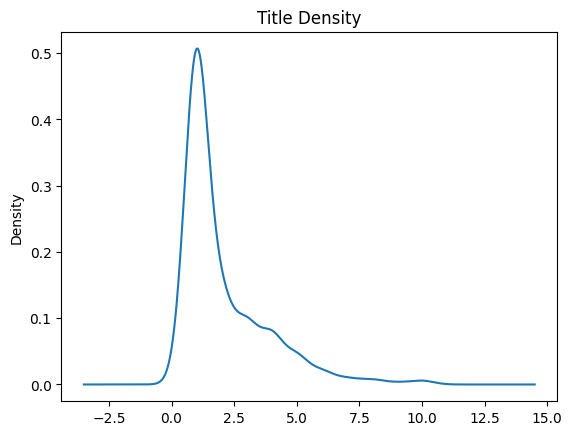

In [12]:
#paintings of the same title;
ax = df_r.groupby('title')['objectNumber'].count().plot.kde()
ax.set_title('Title Density')


<Axes: ylabel='Density'>

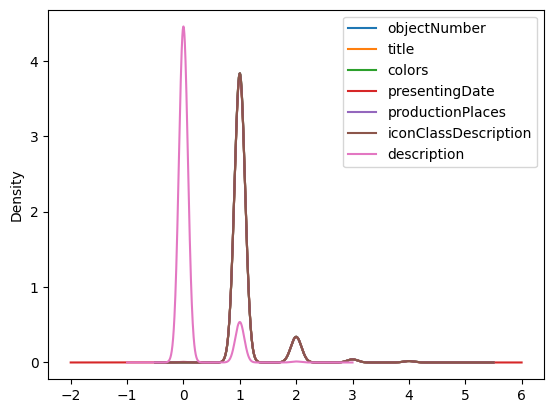

In [13]:
# check desity of each columns grouped by largest_hex;
df_r.groupby('largest_hex').count().plot.kde()
# Most description data is missing 

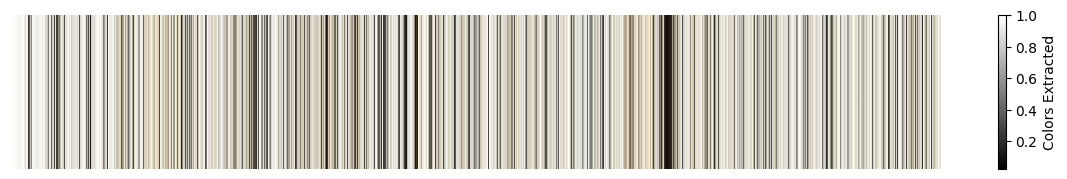

In [11]:
# display colors of all Rambrandt's paintings;
# It's not a heatmap but a color palette;

# Extract hex colors and their frequencies
color_counts = df_r['colors'].apply(lambda x: x[0]['hex']).value_counts()

# Convert hex colors to RGB values
rgb_values = [mcolors.hex2color(c) for c in color_counts.index]

# Create heatmap using grayscale colormap
fig, ax = plt.subplots(figsize=(15,2))
heatmap = ax.imshow([rgb_values], cmap='gray', aspect='auto')

# Hide axis ticks and labels
# ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')

# Add colorbar
cbar = fig.colorbar(heatmap)
cbar.set_label('Colors Extracted')

# Show plot
plt.show()

<Axes: xlabel='smallest_hex', ylabel='largest_hex'>

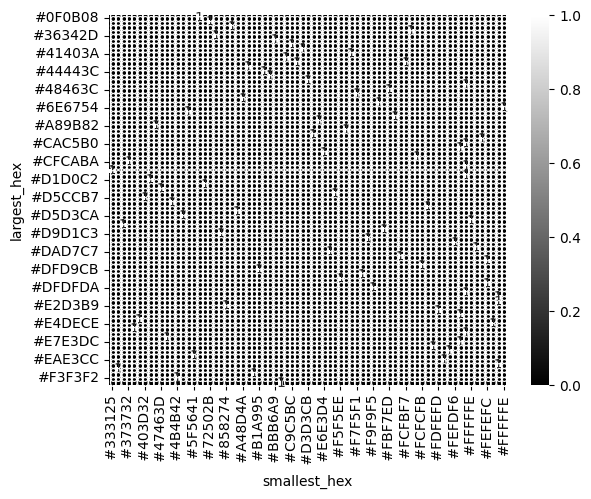

In [23]:
#count the frequency of largest and smallest hex combination in each painting and visualize by a heatmap;
# extract the smallest hex codes for each object
df['smallest_hex'] = df['colors'].apply(lambda x: min(x, key=lambda y: y['percentage'])['hex'])

heatmap_data = df.groupby(['largest_hex', 'smallest_hex']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='gray', annot=True, fmt='d')

In [40]:
#check the value of icon class description;
df_r.iloc[:,[6]]

,iconClassDescription
0,"warfare; military affairs (+ citizen soldiery,..."
1,"historical persons - BB - woman, fan, lace, pe..."
2,"officers trusted with control of quality, tabl..."
4,the apostle Paul of Tarsus; possible attribute...
8,Salome is given the head of John the Baptist b...
...,...
1487,"Simeon, holding the Christ-child, sings his ca..."
1488,Madonna (i.e. Mary with the Christ-child) in t...
1490,head-gear (with NAME)
1503,studying at night


2.1.2 General Icons(Word Cloud)

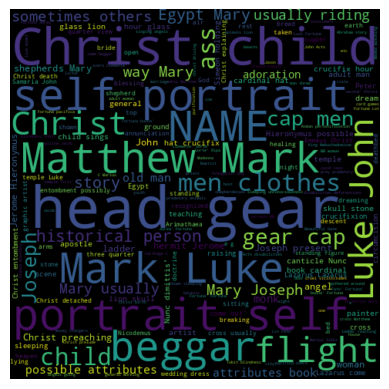

In [50]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# extract a list of icon class description 
descrip_str = " ".join(df_r.iloc[:, 6].astype(str).tolist())
# Create the wordcloud object
wordcloud_des = WordCloud(width=480, height=480, margin=0).generate(descrip_str)
# Display the generated image:
plt.imshow(wordcloud_des, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

2.1.3 General Title

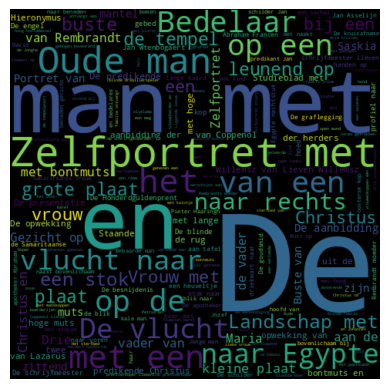

In [51]:
# extract a list of titles 
title_str = " ".join(df_r.iloc[:, 1].astype(str).tolist())
# Create the wordcloud object
wordcloud_tit = WordCloud(width=480, height=480, margin=0).generate(title_str)
# Display the generated image:
plt.imshow(wordcloud_tit, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

**2.2 Color palette**



2.2.1 Color frequency

In [ ]:
#import library
from matplotlib import pyplot as plt

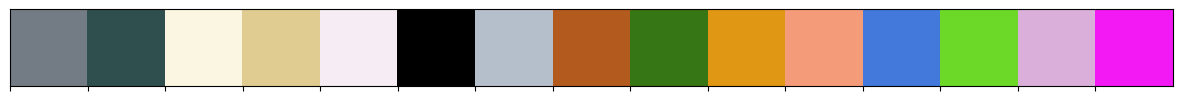

In [ ]:
#show the color palette of Rambrandt;
colors_pal = colors_fre.keys()
#print(color)
sns.palplot(sns.color_palette(colors_pal))

In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import squarify
import matplotlib.pyplot as plt

(0.0, 500.0, 0.0, 500.0)

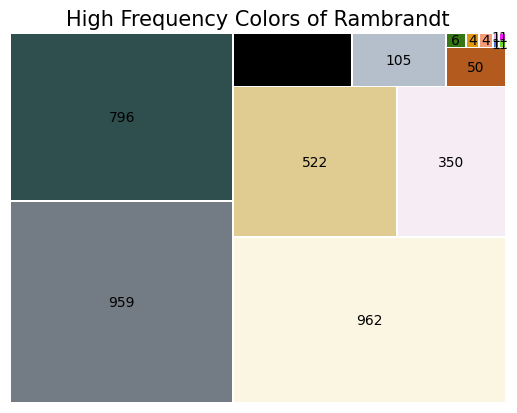

In [ ]:
#show the color frequency in a tree map
data_tree = colors_fre.values()
colors_tree = colors_fre.keys()

axis = squarify.plot(sizes=data_tree, color=colors_tree, pad=2, label=data_tree, norm_x=500, norm_y=500)
axis.set_title("High Frequency Colors of Rambrandt", fontsize=15)
plt.axis("off")

2.2.2 Distribution of colors in each artwork 

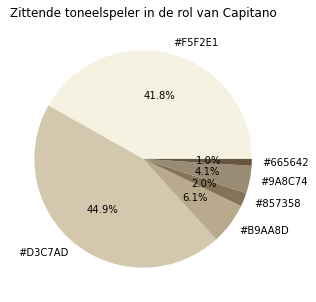

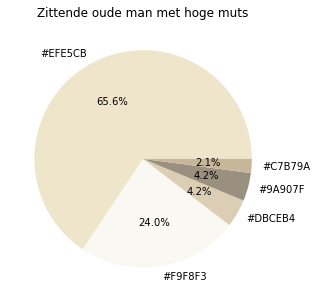

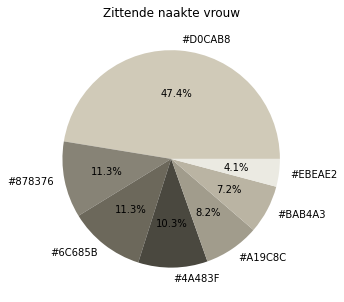

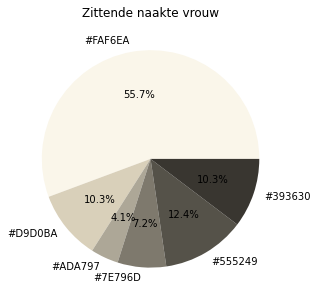

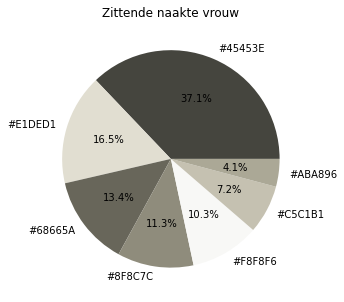

In [5]:
# Sort the dataframe by a certain criterion (e.g., title) in descending order
df_sorted = df_r.sort_values('title', ascending=False)

# Select the top 10 rows from the sorted dataframe
top_10_paintings = df_sorted.head(10)

# Loop over each painting and create a pie chart
for i in range(len(top_10_paintings)):
    # Get the color data for the painting
    colors = top_10_paintings.iloc[i]['colors']
    color_codes = []
    percentages = []
    for color in colors:
        if color['percentage'] != 0:
            color_codes.append(color['hex'].strip())
            percentages.append(color['percentage'])

    # Create the pie chart
    if color_codes and percentages: # check if lists are not empty
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.pie(percentages, labels=color_codes, colors=color_codes, autopct='%1.1f%%')
        ax.set_title(top_10_paintings.iloc[i]['title'])

        # Show the plot
        plt.show()

**2.3 Other factors**

**2.3.1 Time**


In [14]:
#extract colors,largest_hex and date;
df_colortime = df_r[['largest_hex',
          'colors','presentingDate' ]].copy()
df_colortime

,largest_hex,colors,presentingDate
0,#261808,"[{'percentage': 81, 'hex': '#261808'}, {'perce...",1642.0
1,#0B0906,"[{'percentage': 67, 'hex': '#0B0906'}, {'perce...",1639.0
2,#16130C,"[{'percentage': 1, 'hex': '#8B7759'}, {'percen...",1662.0
4,#0B0906,"[{'percentage': 65, 'hex': '#0B0906'}, {'perce...",1661.0
8,#1A140E,"[{'percentage': 41, 'hex': '#1A140E'}, {'perce...",1645.0
...,...,...,...
1487,#4A4942,"[{'percentage': 57, 'hex': '#4A4942'}, {'perce...",1654.0
1488,#E8E2D3,"[{'percentage': 58, 'hex': '#E8E2D3'}, {'perce...",1641.0
1490,#EEE7D6,"[{'percentage': 3, 'hex': '#FDFCF6'}, {'percen...",1710.0
1503,#F7F3E5,"[{'percentage': 50, 'hex': '#F7F3E5'}, {'perce...",1654.0


In [58]:
#extract time perid within 1606-1669(the time of the painter),delete other dates;
df_timeselected = df_colortime.loc[(df_colortime['presentingDate'] <= 1669) & (df_colortime['presentingDate'] > 1606)]
df_timeselected

,largest_hex,colors,presentingDate
0,#261808,"[{'percentage': 81, 'hex': '#261808'}, {'perce...",1642.0
1,#0B0906,"[{'percentage': 67, 'hex': '#0B0906'}, {'perce...",1639.0
2,#16130C,"[{'percentage': 1, 'hex': '#8B7759'}, {'percen...",1662.0
4,#0B0906,"[{'percentage': 65, 'hex': '#0B0906'}, {'perce...",1661.0
8,#1A140E,"[{'percentage': 41, 'hex': '#1A140E'}, {'perce...",1645.0
...,...,...,...
1486,#CEC6B4,"[{'percentage': 29, 'hex': '#CEC6B4'}, {'perce...",1659.0
1487,#4A4942,"[{'percentage': 57, 'hex': '#4A4942'}, {'perce...",1654.0
1488,#E8E2D3,"[{'percentage': 58, 'hex': '#E8E2D3'}, {'perce...",1641.0
1503,#F7F3E5,"[{'percentage': 50, 'hex': '#F7F3E5'}, {'perce...",1654.0


In [15]:
#save to json file;
df_timeselected.to_json(r'/content/timecolor_selected.json')

<Axes: xlabel='presentingDate'>

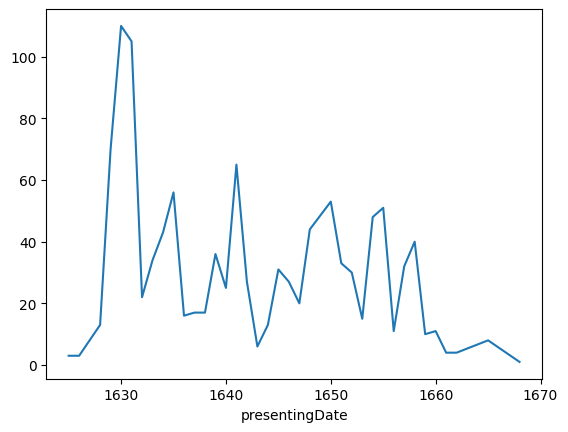

In [27]:
#number of works over time; 
df_timeselected.groupby('presentingDate')['largest_hex'].count().plot.line()
#peak year is around 1630;

([], [])

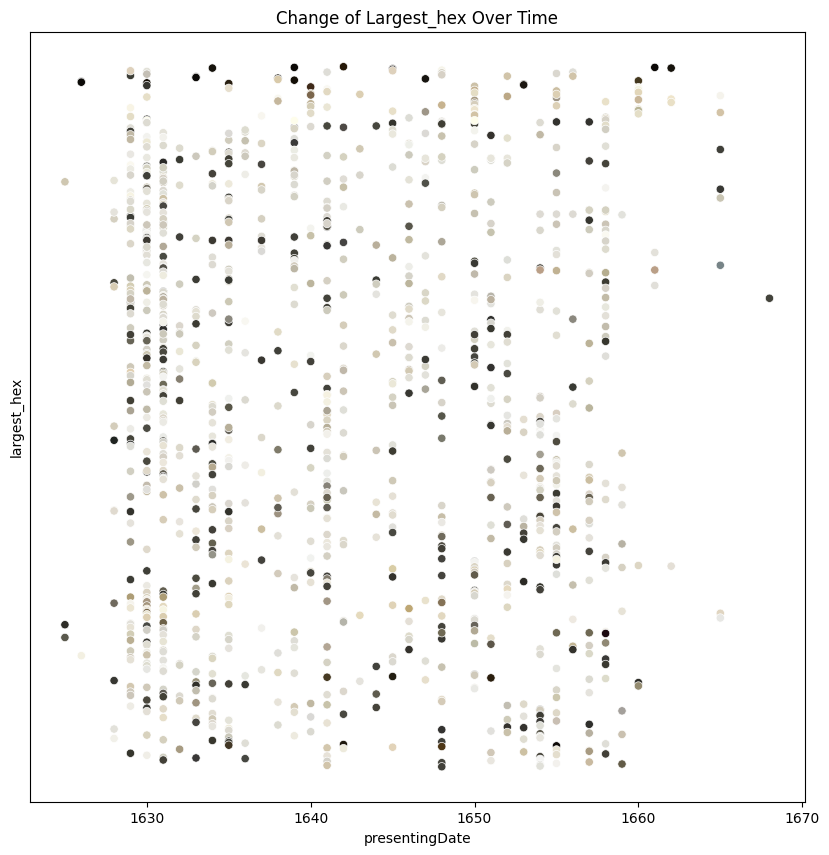

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.scatterplot(data=df_timeselected, x="presentingDate", y="largest_hex", hue='largest_hex', legend=False)
plt.title('Change of Largest_hex Over Time')
plt.yticks([])


From HEX to RGB

In [82]:
# covert largest_hex to RGB value;
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

# Convert the largest_hex column to RGB
df_timeselected['largest_hex_rgb'] = df_timeselected['largest_hex'].apply(hex_to_rgb)

# Split the RGB values into separate columns
df_timeselected[['red', 'green', 'blue']] = pd.DataFrame(df_timeselected['largest_hex_rgb'].tolist(), index=df_timeselected.index)

# Drop the largest_hex_rgb column if you don't need it anymore
df_RGB = df_timeselected.drop(['largest_hex_rgb','colors'], axis=1)
df_RGB

<ipython-input-82-389edf9c53c1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeselected['largest_hex_rgb'] = df_timeselected['largest_hex'].apply(hex_to_rgb)
<ipython-input-82-389edf9c53c1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeselected[['red', 'green', 'blue']] = pd.DataFrame(df_timeselected['largest_hex_rgb'].tolist(), index=df_timeselected.index)
<ipython-input-82-389edf9c53c1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,largest_hex,presentingDate,red,green,blue
0,#261808,1642.0,38,24,8
1,#0B0906,1639.0,11,9,6
2,#16130C,1662.0,22,19,12
4,#0B0906,1661.0,11,9,6
8,#1A140E,1645.0,26,20,14
...,...,...,...,...,...
1486,#CEC6B4,1659.0,206,198,180
1487,#4A4942,1654.0,74,73,66
1488,#E8E2D3,1641.0,232,226,211
1503,#F7F3E5,1654.0,247,243,229


In [21]:
df_RGB.to_json(r'/content/time_RGB.json')

From HEX CODE list to seperate columns;

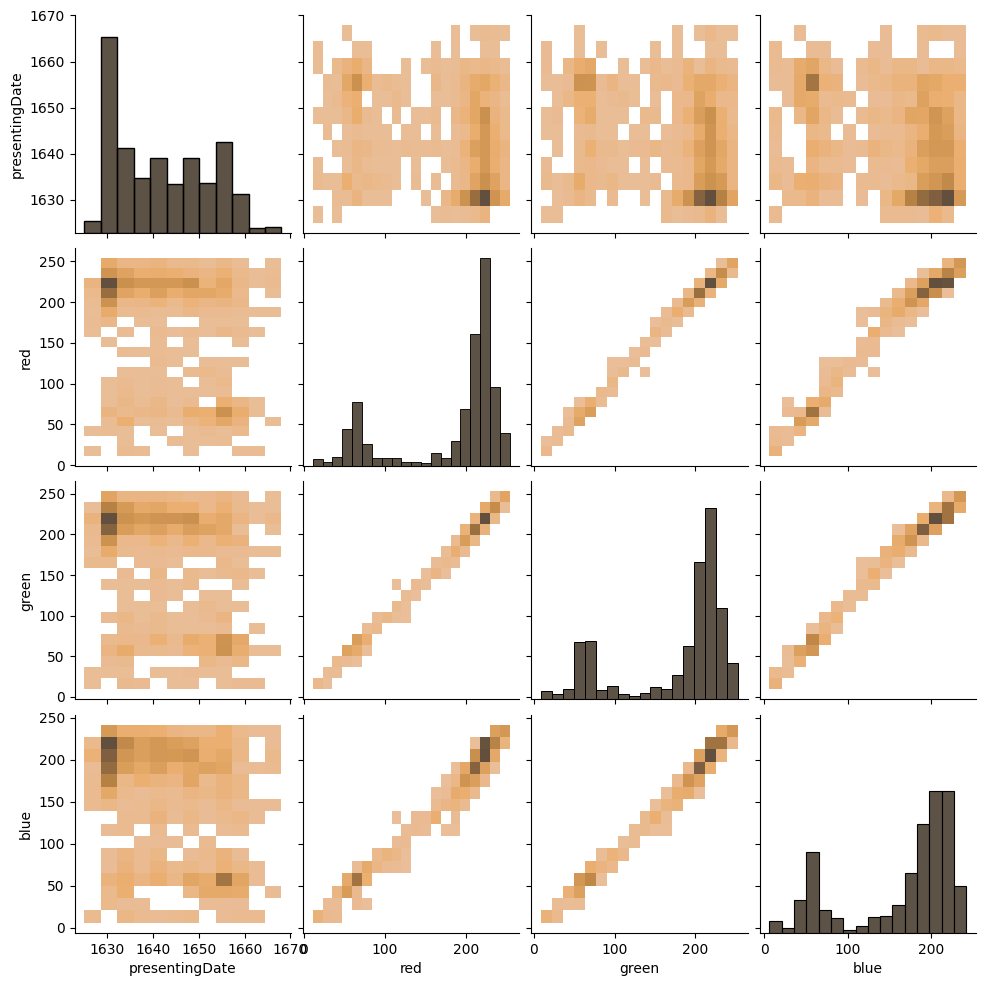

In [110]:
# Basic correlogram
sns.pairplot(df_RGB,kind='hist')
plt.show()

## Summery:
**Rembrandt van Rijn**

**1.Color Palette:**
The colors Rambrandt use most frequently is grey. Although grey and light yellow are the colors that he uses most frequently, the overall tone looks dark, brownish and gloomy. That's partly related to the theme of his paintings.

**2.Theme:**
A significant feature of Rambrandt's paintings is his focus on self-portrait, old man, begger.

**3.Time:**
Rambrandt's peak year is around 1630 when he created more than 100 works.In his late years, there was a drastic decrease in the amount of paintings.

**4.From HEX to RGB**
I extract RGB color and its degree of red, green and blue colors from hex color code. In his early years around 1630, the RGB degree was relativly higher than in 1660.
